## K2000 benchmarking

In [2]:
from k2000 import *

In [ ]:
N_steps = np.array([100,200,400,600,800,1000,2000,4000,
                    6000,8000,10000,20000,40000,60000,
                    80000,100000])
path = './WK2000_1.rud'
J = load_matrix(path,'torch','csr')
batch = 1000
device = 'cuda' 
dtype = torch.float32

In [9]:
cut_dsb_info = np.zeros([4, N_steps.shape[0]])
dsb_params = load_params('dsb')
for ii in range(N_steps.shape[0]):
    print("N_steps:", N_steps[ii])
    dsb = SBM(-J, N_step = N_steps[ii], dt=dsb_params['dt'], 
              trials=batch, seed = dsb_params['seed'][ii], dev=device,dtype=dtype)
    dsb.iterate()
    run_time = np.cumsum(np.array(dsb.run_time))
    dsbcut = dsb.calculate_cut().cpu().numpy()
    dsbcutmax  = dsbcut.max(0)
    print('dsb cutmax:', dsbcutmax)
    dsbcutmean  = dsbcut.mean(0)
    dsbcutmin  = dsbcut.min(0)
    cut_dsb_info[0,ii] = dsbcutmax
    cut_dsb_info[1,ii] = dsbcutmean
    cut_dsb_info[2,ii] = dsbcutmin
    cut_dsb_info[3,ii] = run_time[-1]/batch

N_steps: 100


dsb cutmax: 33035.0
N_steps: 200
dsb cutmax: 33169.0
N_steps: 400
dsb cutmax: 33264.0
N_steps: 600
dsb cutmax: 33290.0
N_steps: 800
dsb cutmax: 33296.0
N_steps: 1000
dsb cutmax: 33310.0
N_steps: 2000
dsb cutmax: 33337.0
N_steps: 4000
dsb cutmax: 33337.0
N_steps: 6000
dsb cutmax: 33337.0
N_steps: 8000
dsb cutmax: 33337.0
N_steps: 10000
dsb cutmax: 33337.0
N_steps: 20000
dsb cutmax: 33337.0
N_steps: 40000
dsb cutmax: 33337.0
N_steps: 60000
dsb cutmax: 33337.0
N_steps: 80000
dsb cutmax: 33337.0
N_steps: 100000
dsb cutmax: 33337.0


### Notice that since we have used the sparse matrix multiplication of PyTorch to favor speedup, which involves some randomized procedures during the computation (i.e., it is not deterministic), one may not reproduce the same results even with the seeds fixed. Try running it multiple times.

In [8]:
cut_fem_info = np.zeros([4, N_steps.shape[0]])
fem_params = load_params('fem')
for ii in range(N_steps.shape[0]):
    print("N_steps:", N_steps[ii])
    beta = 1/np.linspace(fem_params['Tmax'], fem_params['Tmin'], N_steps[ii])
    fem = FEM(J, beta, fem_params['lr'], batch, c_grad=fem_params['c_grad'], dev=device,
              dtype=dtype, seed=fem_params['seed'][ii], wd = fem_params['wd'], 
              alpha = fem_params['alpha'], mom=fem_params['mom'], q=2, h_factor = fem_params['h_factor'])
    fem.iterate()
    config, cut = fem.calculate_results()
    fem_cut = cut.cpu().numpy()
    run_time = np.cumsum(np.array(fem.run_time))
    femcutmax  = fem_cut.max(0)
    print('fem cutmax:', femcutmax)
    femcutmean  = fem_cut.mean(0)
    femcutmin  = fem_cut.min(0)
    cut_fem_info[0,ii] = femcutmax
    cut_fem_info[1,ii] = femcutmean
    cut_fem_info[2,ii] = femcutmin
    cut_fem_info[3,ii] = run_time[-1]/batch
    

N_steps: 100
fem cutmax: 33197.0
N_steps: 200
fem cutmax: 33246.0
N_steps: 400
fem cutmax: 33293.0
N_steps: 600
fem cutmax: 33337.0
N_steps: 800
fem cutmax: 33337.0
N_steps: 1000
fem cutmax: 33336.0
N_steps: 2000
fem cutmax: 33336.0
N_steps: 4000
fem cutmax: 33337.0
N_steps: 6000
fem cutmax: 33337.0
N_steps: 8000
fem cutmax: 33337.0
N_steps: 10000
fem cutmax: 33336.0
N_steps: 20000
fem cutmax: 33337.0
N_steps: 40000
fem cutmax: 33337.0
N_steps: 60000
fem cutmax: 33337.0
N_steps: 80000
fem cutmax: 33337.0
N_steps: 100000
fem cutmax: 33337.0


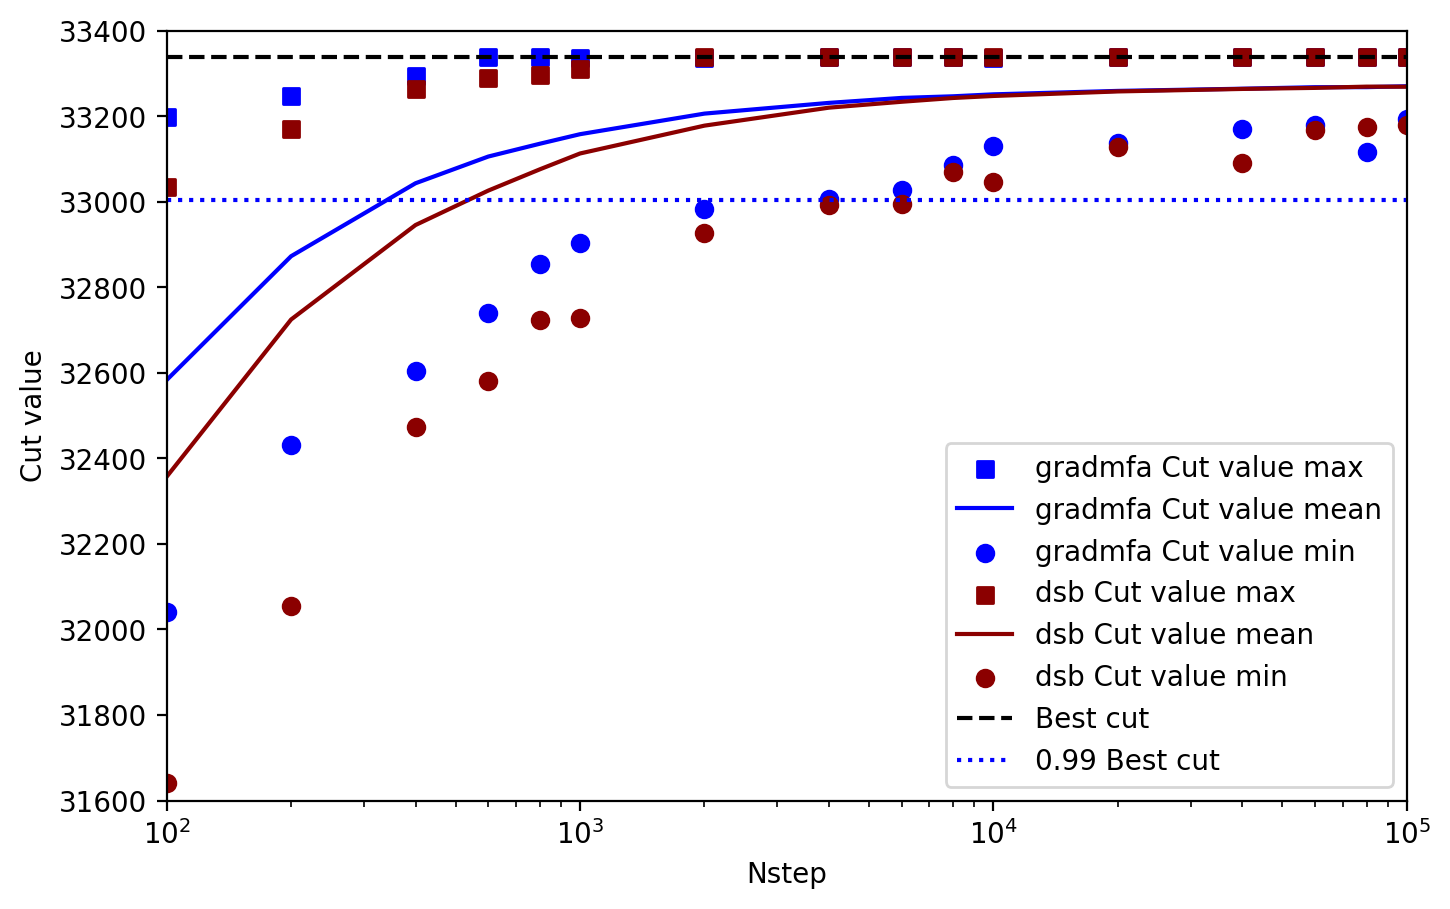

In [10]:
plt.figure(figsize=(8,5),dpi=200)
ax  = plt.subplot(111)
ax.set_ylabel("Cut value")
ax.set_xlabel("Nstep")
ax.set_xscale('log')

ax.scatter(N_steps[::1],cut_fem_info[0,:][::1], marker='s',color='blue', label='gradmfa Cut value max')
ax.plot(N_steps[::1],cut_fem_info[1,:][::1],color='blue', label='gradmfa Cut value mean')
ax.scatter(N_steps[::1],cut_fem_info[2,:][::1], marker='o',color='blue', label='gradmfa Cut value min')

ax.scatter(N_steps[::1],cut_dsb_info[0,:][::1],  marker='s',color='darkred', label='dsb Cut value max')
ax.plot(N_steps[::1],cut_dsb_info[1,:][::1],color='darkred', label='dsb Cut value mean')
ax.scatter(N_steps[::1],cut_dsb_info[2,:][::1],  marker='o',color='darkred', label='dsb Cut value min')
ax.plot(N_steps[::1],np.ones((cut_dsb_info[0,:][::1]).shape[0])*33337,ls='--',color='black',label='Best cut')
ax.plot(N_steps[::1],np.ones((cut_dsb_info[0,:][::1]).shape[0])*33337*0.99,ls=':',color='blue',label='0.99 Best cut')

plt.legend()
plt.xlim(100,100000)
plt.ylim(31600,33400)
plt.show()